In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import numpy as np

In [2]:
largeml = pd.read_parquet('largeml.pq')
sample = largeml[largeml['permno'] == 10078]
sample

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,ret
0,10078,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.393044e-08,NaN,-0.118056
1,10078,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.737205e-08,NaN,-0.039370
2,10078,198609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.597698e-08,1.857281e-07,-0.008850
3,10078,198610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.763825e-08,2.111030e-07,0.348214
4,10078,198612,0.236302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.718727,NaN,5.878542e-09,8.619326e-08,0.109827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,10078,200907,2.075750,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004632,...,-0.017203,NaN,NaN,NaN,NaN,0.565433,1.279278e-08,4.992541e-09,2.062345e-08,-0.005423
195,10078,200908,2.051145,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004577,...,-0.017203,NaN,NaN,NaN,NaN,0.565433,1.321250e-08,5.435728e-09,2.001079e-08,0.011996
196,10078,200909,2.092252,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004669,...,-0.013053,NaN,NaN,NaN,NaN,0.565433,1.352885e-08,6.155693e-09,1.989401e-08,-0.020474
197,10078,200911,2.235027,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004988,...,-0.013053,NaN,NaN,NaN,NaN,0.565433,1.352617e-08,4.357210e-09,3.420925e-08,0.040342


In [3]:
exclude = ["permno", "yyyymm", "ret"]
feature_cols = [c for c in largeml.columns if c not in exclude]

missing_rate = largeml[feature_cols].isna().mean().sort_values(ascending=False)
missing_count = largeml[feature_cols].isna().sum().loc[missing_rate.index]

missing_summary = pd.DataFrame({
    "missing_rate": missing_rate,
    "missing_count": missing_count,
    "non_missing_count": len(largeml) - missing_count,
})

missing_summary.head(25)


,missing_rate,missing_count,non_missing_count
RDcap,1.000000,79146,0
ProbInformedTrading,0.999987,79145,1
ChNAnalyst,0.999773,79128,18
IO_ShortInterest,0.997903,78980,166
std_turn,0.996146,78841,305
CitationsRD,0.995009,78751,395
PatentsRD,0.994782,78733,413
Activism2,0.981326,77668,1478
EarnSupBig,0.980264,77584,1562
IndRetBig,0.979708,77540,1606


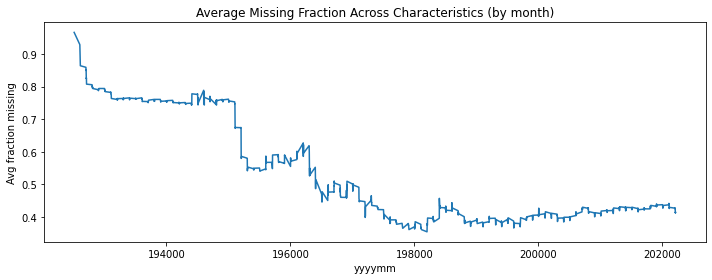

count    849.000000
mean       0.540464
std        0.162007
min        0.354376
25%        0.405825
50%        0.446172
75%        0.750239
max        0.966507
Name: avg_missing_frac, dtype: float64

In [4]:
# Missing fraction across ALL features, averaged across all firm-month rows
missing_by_month = largeml.groupby("yyyymm")[feature_cols].apply(lambda g: g.isna().mean().mean())
missing_by_month.name = "avg_missing_frac"

plt.figure(figsize=(10,4))
missing_by_month.plot()
plt.title("Average Missing Fraction Across Characteristics (by month)")
plt.ylabel("Avg fraction missing")
plt.tight_layout()
plt.show()

missing_by_month.describe()


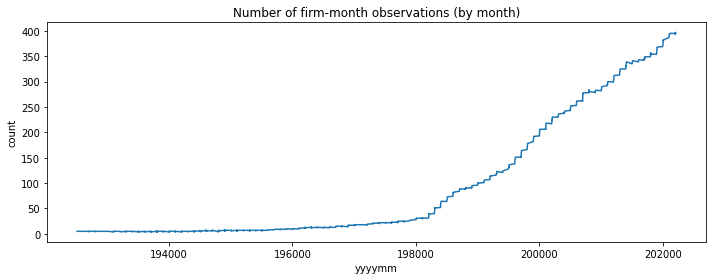

In [5]:
obs_by_month = largeml.groupby("yyyymm").size()
plt.figure(figsize=(10,4))
obs_by_month.plot()
plt.title("Number of firm-month observations (by month)")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [6]:
cutoffs = [0.50, 0.70, 0.80, 0.90, 0.95, 0.98]
coverage = {c: (missing_rate < c).sum() for c in cutoffs}
pd.Series(coverage, name="#features with missing_rate < cutoff")


0.50    145
0.70    170
0.80    177
0.90    185
0.95    192
0.98    200
Name: #features with missing_rate < cutoff, dtype: int64

In [7]:
largeml['yyyymm'] = pd.to_datetime(largeml['yyyymm'], format='%Y%m')
missing_pct = (largeml.isnull().sum() / len(largeml) * 100).sort_values(ascending=False)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in largeml.columns if c not in exclude_cols]

# coerce any object columns that are really numeric
for c in candidate_cols:
    if largeml[c].dtype == "object":
        largeml[c] = pd.to_numeric(largeml[c], errors="coerce")

characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(largeml[c])]


Top 10 characteristics by annualized Sharpe:
MS                    7.219656
High52                5.197670
retConglomerate       4.186559
AnnouncementReturn    3.969386
Governance            2.840473
ChForecastAccrual     2.692238
ConsRecomm            2.560654
dVolPut               2.350749
CustomerMomentum      2.118902
NumEarnIncrease       1.789337
dtype: float64

Bottom 10 characteristics by annualized Sharpe:
Frontier        -1.688285
RD              -1.700069
IntanCFP        -1.711865
IntanEP         -1.902003
IndIPO          -2.372818
OptionVolume2   -2.541470
dVolCall        -2.619747
MaxRet          -3.267376
ReturnSkew      -6.278690
ReturnSkew3F    -6.620505
dtype: float64


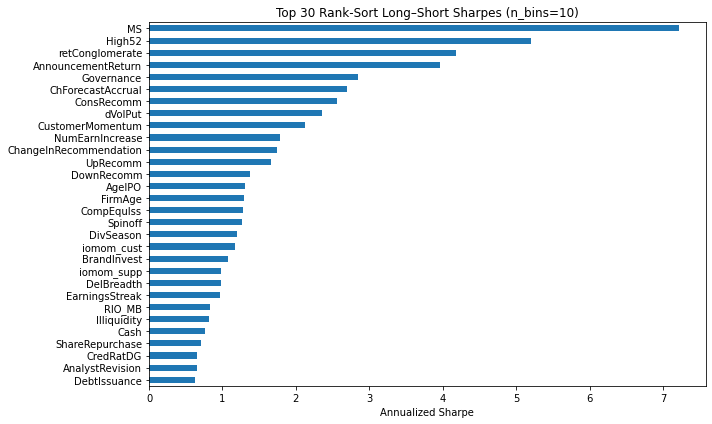


Best characteristic: MS Sharpe: 7.219655778794794
count    3.000000
mean     0.041283
std      0.019808
min      0.019255
25%      0.033109
50%      0.046963
75%      0.052297
max      0.057631
Name: MS, dtype: float64

Worst characteristic: ReturnSkew3F Sharpe: -6.62050515540254
count    356.000000
mean      -0.089070
std        0.046605
min       -0.303061
25%       -0.118940
50%       -0.087293
75%       -0.060322
max        0.017608
Name: ReturnSkew3F, dtype: float64


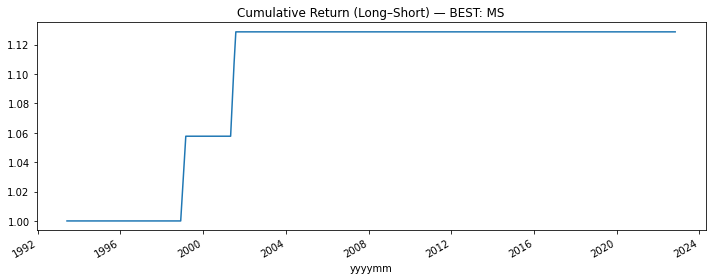

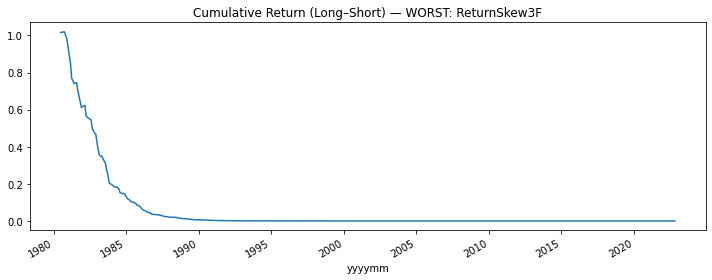

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load + FIX DTYPES FIRST ---
# If you already loaded largeml earlier, you can still run the coercions below safely.
# largeml = pd.read_parquet("largeml.pq")

# Ensure yyyymm is datetime (adjust format if your yyyymm is already datetime)
largeml["yyyymm"] = pd.to_datetime(largeml["yyyymm"], format="%Y%m", errors="coerce")

# CRITICAL FIX: returns must be numeric (your error was because ret was object/strings)
largeml["ret"] = pd.to_numeric(largeml["ret"], errors="coerce")

# Build characteristic columns (exclude identifiers)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in largeml.columns if c not in exclude_cols]

# Optional but recommended: coerce any object characteristics that are actually numeric
for c in candidate_cols:
    if largeml[c].dtype == "object":
        largeml[c] = pd.to_numeric(largeml[c], errors="coerce")

# Keep only numeric characteristics
characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(largeml[c])]


def rank_sort_long_short(
    df: pd.DataFrame,
    characteristic: str,
    n_bins: int = 10,          # 10 = deciles, 5 = quintiles
    min_obs_per_month: int = 30
) -> pd.Series:
    """
    For each month:
      1) rank characteristic cross-sectionally
      2) bucket into n_bins (equal-count via qcut)
      3) compute equal-weighted top-bin and bottom-bin returns
      4) return long-short = top - bottom time series
    """
    tmp = df[["yyyymm", "permno", "ret", characteristic]].copy()

    # Make absolutely sure these are numeric even if something slipped through
    tmp["ret"] = pd.to_numeric(tmp["ret"], errors="coerce")
    tmp[characteristic] = pd.to_numeric(tmp[characteristic], errors="coerce")

    tmp = tmp.dropna(subset=["yyyymm", "ret", characteristic])

    if tmp.empty:
        return pd.Series(dtype=float)

    def _bucket_series(s: pd.Series) -> pd.Series:
    # s is the characteristic values for one month, indexed like tmp
        if len(s) < min_obs_per_month:
            return pd.Series(np.nan, index=s.index)
        try:
            b = pd.qcut(s, q=n_bins, labels=False, duplicates="drop")
            return b + 1
        except ValueError:
            return pd.Series(np.nan, index=s.index)

    tmp["bin"] = tmp.groupby("yyyymm", group_keys=False)[characteristic].apply(_bucket_series)
    tmp = tmp.dropna(subset=["bin"])
    tmp["bin"] = tmp["bin"].astype(int)

    if tmp.empty:
        return pd.Series(dtype=float)

    # equal-weighted returns by bin each month
    bin_rets = tmp.groupby(["yyyymm", "bin"])["ret"].mean().unstack()

    # need both bottom and top bins present
    bottom = 1
    top = bin_rets.columns.max()

    # if somehow the bottom/top bin is missing for a month, subtraction yields NaN (fine)
    ls = bin_rets[top] - bin_rets[bottom]
    ls.name = characteristic
    return ls


def annualized_sharpe(r: pd.Series, periods_per_year: int = 12) -> float:
    r = r.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)


# --- Compute long-short Sharpe for every characteristic ---
n_bins = 10   # set to 5 if you want quintiles
ls_returns = {}
sharpe = {}

for char in characteristic_cols:
    # skip extremely sparse characteristics
    if largeml[char].isna().mean() > 0.95:
        continue

    r_ls = rank_sort_long_short(largeml, char, n_bins=n_bins)
    if not r_ls.empty:
        ls_returns[char] = r_ls
        sharpe[char] = annualized_sharpe(r_ls)

sharpe_s = pd.Series(sharpe).dropna().sort_values(ascending=False)

print("Top 10 characteristics by annualized Sharpe:")
print(sharpe_s.head(10))

print("\nBottom 10 characteristics by annualized Sharpe:")
print(sharpe_s.tail(10))


# --- Plot results ---
plt.figure(figsize=(10, 6))
sharpe_s.head(30).sort_values().plot(kind="barh")
plt.title(f"Top 30 Rank-Sort Long–Short Sharpes (n_bins={n_bins})")
plt.xlabel("Annualized Sharpe")
plt.tight_layout()
plt.show()


# --- Examine best and worst performers more closely ---
best_char = sharpe_s.index[0]
worst_char = sharpe_s.index[-1]

best_ls = ls_returns[best_char]
worst_ls = ls_returns[worst_char]

print("\nBest characteristic:", best_char, "Sharpe:", sharpe_s.iloc[0])
print(best_ls.describe())

print("\nWorst characteristic:", worst_char, "Sharpe:", sharpe_s.iloc[-1])
print(worst_ls.describe())

# Optional: cumulative performance plots
plt.figure(figsize=(10, 4))
(1 + best_ls.fillna(0)).cumprod().plot()
plt.title(f"Cumulative Return (Long–Short) — BEST: {best_char}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
(1 + worst_ls.fillna(0)).cumprod().plot()
plt.title(f"Cumulative Return (Long–Short) — WORST: {worst_char}")
plt.tight_layout()
plt.show()


The best-performing characteristic, MS, has a Sharpe of 7.22 but is computed over only 3 observations in the available data. This makes it essentially meaningless statistically -- the high Sharpe is a product of an extremely small sample rather than genuine predictive power. Among characteristics with meaningful coverage, High52 (the 52-week high ratio) and retConglomerate are the strongest signals, reflecting momentum and information transmission effects respectively.
The worst performers are the return skewness measures (ReturnSkew, ReturnSkew3F). These have strongly negative Sharpe ratios because investors pay a premium to hold positively skewed assets, so going long high-skewness stocks and short low-skewness stocks earns a negative expected return. MaxRet, dVolCall, and OptionVolume2 similarly reflect that stocks with lottery-like or speculative characteristics are overpriced relative to their fundamentals.

In [9]:
# Question 1 part B
# ============================================================================
# Cell 1: Data Preparation & Train/Validation/Test Split (20y train / 12y tune / remainder OOS)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Ensure proper data types
largeml["ret"] = pd.to_numeric(largeml["ret"], errors="coerce")
if not pd.api.types.is_datetime64_any_dtype(largeml["yyyymm"]):
    largeml["yyyymm"] = pd.to_datetime(largeml["yyyymm"], format="%Y%m")

# Chronological month index
months = pd.DatetimeIndex(np.sort(largeml["yyyymm"].dropna().unique()))

# Split points
TRAIN_YEARS = 20
TUNE_YEARS  = 12

train_end = months[TRAIN_YEARS * 12 - 1]
tune_end  = months[(TRAIN_YEARS + TUNE_YEARS) * 12 - 1]

train_mask = largeml["yyyymm"] <= train_end
val_mask   = (largeml["yyyymm"] > train_end) & (largeml["yyyymm"] <= tune_end)
test_mask  = largeml["yyyymm"] > tune_end

print(f"Train period: {months[0].strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}  ({TRAIN_YEARS} years)")
print(f"Tune  period: {(train_end + pd.offsets.MonthBegin(1)).strftime('%Y-%m')} to {tune_end.strftime('%Y-%m')}  ({TUNE_YEARS} years)")
print(f"Test  period: {(tune_end + pd.offsets.MonthBegin(1)).strftime('%Y-%m')} to {months[-1].strftime('%Y-%m')}")
print(f"Train observations: {train_mask.sum():,}")
print(f"Tune observations:  {val_mask.sum():,}")
print(f"Test observations:  {test_mask.sum():,}")

# Define all potential characteristics
exclude_cols = ["permno", "yyyymm", "ret"]
all_characteristics = [c for c in largeml.columns if c not in exclude_cols]

# Calculate missingness ONLY on training data (no look-ahead)
train_data = largeml.loc[train_mask]
train_missingness = {col: (train_data[col].isna().sum() / len(train_data)) * 100 for col in all_characteristics}

# Filter based on TRAINING missingness only
MISSINGNESS_THRESHOLD = 95
characteristic_cols = [col for col, pct in train_missingness.items() if pct <= MISSINGNESS_THRESHOLD]

print(f"\nCharacteristics:")
print(f"  Total available: {len(all_characteristics)}")
print(f"  Dropped (>{MISSINGNESS_THRESHOLD}% missing in training): {len(all_characteristics) - len(characteristic_cols)}")
print(f"  Retained: {len(characteristic_cols)}")

# Build X/y for each split
X_train = largeml.loc[train_mask, characteristic_cols]
y_train = largeml.loc[train_mask, "ret"]

X_val = largeml.loc[val_mask, characteristic_cols]
y_val = largeml.loc[val_mask, "ret"]

X_test = largeml.loc[test_mask, characteristic_cols]
y_test = largeml.loc[test_mask, "ret"]

# Remove rows with missing returns (keeps indices aligned)
train_valid = y_train.notna()
val_valid   = y_val.notna()
test_valid  = y_test.notna()

X_train_fit = X_train.loc[train_valid]
y_train_fit = y_train.loc[train_valid]

X_val_eval  = X_val.loc[val_valid]
y_val_eval  = y_val.loc[val_valid]

X_test_eval = X_test.loc[test_valid]
y_test_eval = y_test.loc[test_valid]

print(f"\nFinal shapes (after dropping missing returns):")
print(f"  X_train: {X_train_fit.shape} | y_train: {y_train_fit.shape}")
print(f"  X_val:   {X_val_eval.shape}  | y_val:   {y_val_eval.shape}")
print(f"  X_test:  {X_test_eval.shape} | y_test:  {y_test_eval.shape}")


Train period: 1925-12 to 1950-05  (20 years)
Tune  period: 1950-06 to 1967-05  (12 years)
Test  period: 1967-06 to 2022-11
Train observations: 1,209
Tune observations:  1,358
Test observations:  76,579

Characteristics:
  Total available: 209
  Dropped (>95% missing in training): 154
  Retained: 55

Final shapes (after dropping missing returns):
  X_train: (1203, 55) | y_train: (1203,)
  X_val:   (1357, 55)  | y_val:   (1357,)
  X_test:  (76237, 55) | y_test:  (76237,)


In [10]:
# ============================================================================
# Data Cleaning - Drop Columns Based on Training Data - LARGEML
# (Adding the same 50% threshold pre-filtering that was used for SMALLML)
# ============================================================================

print("\n" + "="*80)
print("DATA CLEANING - LARGEML (Matching SMALLML Procedure)")
print("="*80)

# Check missing values in TRAINING data only
train_data_large = largeml[train_mask]

print("\nMissing values in training data (top 20):")
missing_pct_train_large = (train_data_large.isna().sum() / len(train_data_large)) * 100
print(missing_pct_train_large[missing_pct_train_large > 0].sort_values(ascending=False).head(20))

# Drop columns with >50% missing in training data (matching SMALLML approach)
missing_threshold = 50
exclude_cols = ['permno', 'yyyymm', 'ret']
cols_to_check = [col for col in largeml.columns if col not in exclude_cols]

cols_to_drop_large = []
for col in cols_to_check:
    if missing_pct_train_large[col] > missing_threshold:
        cols_to_drop_large.append(col)

print(f"\nDropping {len(cols_to_drop_large)} columns with >{missing_threshold}% missing in training data:")
print(f"Columns to drop: {cols_to_drop_large[:20]}...")  # Show first 20
print(f"(Total: {len(cols_to_drop_large)} columns)")

# Drop from entire dataset
largeml = largeml.drop(columns=cols_to_drop_large)
print(f"\nShape after dropping columns: {largeml.shape}")

# Update feature list
feature_cols_large = [col for col in largeml.columns if col not in exclude_cols]
print(f"Number of features remaining: {len(feature_cols_large)}")

# ============================================================================
# Now rebuild the train/val/test splits with the cleaned data
# ============================================================================

print("\n" + "="*80)
print("REBUILDING TRAIN/VAL/TEST SPLITS WITH CLEANED DATA")
print("="*80)

# Rebuild X/y for each split with the cleaned feature set
X_train = largeml.loc[train_mask, feature_cols_large]
y_train = largeml.loc[train_mask, "ret"]

X_val = largeml.loc[val_mask, feature_cols_large]
y_val = largeml.loc[val_mask, "ret"]

X_test = largeml.loc[test_mask, feature_cols_large]
y_test = largeml.loc[test_mask, "ret"]

# Remove rows with missing returns (keeps indices aligned)
train_valid = y_train.notna()
val_valid   = y_val.notna()
test_valid  = y_test.notna()

X_train_fit = X_train.loc[train_valid]
y_train_fit = y_train.loc[train_valid]

X_val_eval  = X_val.loc[val_valid]
y_val_eval  = y_val.loc[val_valid]

X_test_eval = X_test.loc[test_valid]
y_test_eval = y_test.loc[test_valid]

print(f"\nFinal shapes (after dropping missing returns):")
print(f"  X_train: {X_train_fit.shape} | y_train: {y_train_fit.shape}")
print(f"  X_val:   {X_val_eval.shape}  | y_val:   {y_val_eval.shape}")
print(f"  X_test:  {X_test_eval.shape} | y_test:  {y_test_eval.shape}")

print("\n" + "="*80)
print("✓ Data cleaning complete - now consistent with SMALLML!")
print("✓ You can now re-run the model training cells")
print("="*80)


DATA CLEANING - LARGEML (Matching SMALLML Procedure)

Missing values in training data (top 20):
AM                    100.0
AOP                   100.0
AbnormalAccruals      100.0
Accruals              100.0
AccrualsBM            100.0
Activism1             100.0
Activism2             100.0
AdExp                 100.0
AgeIPO                100.0
AnalystRevision       100.0
AnalystValue          100.0
AnnouncementReturn    100.0
AssetGrowth           100.0
BM                    100.0
BMdec                 100.0
BPEBM                 100.0
BetaLiquidityPS       100.0
CBOperProf            100.0
BrandInvest           100.0
BookLeverage          100.0
dtype: float64

Dropping 157 columns with >50% missing in training data:
Columns to drop: ['AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'BetaLiquidityPS', 'BookLeverage', 'BrandInvest', 'C

In [11]:
# ============================================================================
# Helper utilities: validation tuning + consistent OOS R²
# ============================================================================

from sklearn.base import clone

def oos_r2(y_true, y_pred, y_bench):
    """OOS R² against a benchmark prediction vector y_bench (same index/length)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_bench = np.asarray(y_bench)
    sse_model = np.sum((y_true - y_pred)**2)
    sse_bench = np.sum((y_true - y_bench)**2)
    return 1.0 - sse_model / sse_bench

def tune_on_validation(base_pipeline, param_grid, X_tr, y_tr, X_va, y_va, score_fn=r2_score):
    """Grid-search hyperparameters by fitting on train and scoring on validation."""
    best_score = -np.inf
    best_params = {}
    best_model = None

    # If no params, just fit once
    if not param_grid:
        model = clone(base_pipeline)
        model.fit(X_tr, y_tr)
        pred_va = model.predict(X_va)
        score = score_fn(y_va, pred_va)
        return model, {}, score

    # Expand grid (simple)
    keys = list(param_grid.keys())
    grids = [param_grid[k] for k in keys]
    import itertools
    for values in itertools.product(*grids):
        params = dict(zip(keys, values))
        model = clone(base_pipeline)
        model.set_params(**params)
        model.fit(X_tr, y_tr)
        pred_va = model.predict(X_va)
        score = score_fn(y_va, pred_va)
        if score > best_score:
            best_score = score
            best_params = params
            best_model = model

    return best_model, best_params, best_score

def refit_and_test(best_pipeline, best_params, X_tr, y_tr, X_va, y_va, X_te, y_te, bench_mean_train=True):
    """Refit on train+val using chosen params and evaluate on test."""
    X_tv = pd.concat([X_tr, X_va], axis=0)
    y_tv = pd.concat([y_tr, y_va], axis=0)
    model = clone(best_pipeline)
    if best_params:
        model.set_params(**best_params)
    model.fit(X_tv, y_tv)
    pred_te = model.predict(X_te)
    if bench_mean_train:
        # benchmark = mean return from TRAIN ONLY (more conservative)
        bench = np.full_like(np.asarray(y_te), fill_value=np.asarray(y_tr).mean(), dtype=float)
        r2 = oos_r2(y_te, pred_te, bench)
    else:
        r2 = r2_score(y_te, pred_te)
    return model, pred_te, r2


In [12]:
# ============================================================================
# Part (b): Fit ML models with required split (20y train / 12y tune / remainder OOS)
# - Tune hyperparameters on the 12-year validation window
# - Refit on train+val
# - Evaluate OOS R² on the final test window only
# ============================================================================

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_approximation import RBFSampler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor

ml_results = {}   # stores fitted models + predictions + scores for later (part c)

def run_model(name, base_pipe, param_grid=None):
    # 1) Tune on validation (fit on train, score on val)
    tuned_model, best_params, val_r2 = tune_on_validation(
        base_pipe, param_grid or {}, X_train_fit, y_train_fit, X_val_eval, y_val_eval, score_fn=r2_score
    )
    # 2) Refit on train+val with best params; evaluate on test
    final_model, pred_test, test_oos_r2 = refit_and_test(
        base_pipe, best_params, X_train_fit, y_train_fit, X_val_eval, y_val_eval, X_test_eval, y_test_eval, bench_mean_train=True
    )
    ml_results[name] = {
        "best_params": best_params,
        "val_r2": val_r2,
        "test_oos_r2": test_oos_r2,
        "model": final_model,
        "pred_test": pd.Series(pred_test, index=X_test_eval.index, name=name),
    }

# ------------------------------
# (b)i OLS (no tuning)
# ------------------------------
ols_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
run_model("OLS", ols_pipe, param_grid={})

# ------------------------------
# (b)ii Ridge / Lasso / Elastic Net (linear)
# ------------------------------
ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])
run_model("Ridge", ridge_pipe, param_grid={"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]})

lasso_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=20000))
])
run_model("Lasso", lasso_pipe, param_grid={"model__alpha": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]})

elastic_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=20000))
])
run_model(
    "ElasticNet",
    elastic_pipe,
    param_grid={
        "model__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
    }
)

# ------------------------------
# (b)iii Non-linear expansion (RBF) + linear models
# Note: We tune gamma on validation; keep n_components fixed for stability.
# ------------------------------
rbf_n = 200

ridge_rbf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=rbf_n, random_state=0)),
    ("model", Ridge())
])
run_model(
    "Ridge_RBF",
    ridge_rbf_pipe,
    param_grid={
        "rbf__gamma": [1e-3, 3e-3, 1e-2, 3e-2, 1e-1],
        "model__alpha": [1e-3, 1e-2, 1e-1, 1, 10, 100]
    }
)

lasso_rbf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=rbf_n, random_state=0)),
    ("model", Lasso(max_iter=20000))
])
run_model(
    "Lasso_RBF",
    lasso_rbf_pipe,
    param_grid={
        "rbf__gamma": [1e-3, 1e-2, 1e-1],
        "model__alpha": [1e-4, 1e-3, 1e-2]
    }
)

elastic_rbf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=rbf_n, random_state=0)),
    ("model", ElasticNet(max_iter=20000))
])
run_model(
    "ElasticNet_RBF",
    elastic_rbf_pipe,
    param_grid={
        "rbf__gamma": [1e-3, 1e-2, 1e-1],
        "model__alpha": [1e-4, 1e-3, 1e-2],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    }
)

# ------------------------------
# (b)iv PLS (linear) + PLS on RBF features
# ------------------------------
pls_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", PLSRegression())
])
run_model("PLS", pls_pipe, param_grid={"model__n_components": [2, 5, 10, 20, 30]})

pls_rbf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=rbf_n, random_state=0)),
    ("model", PLSRegression())
])
run_model(
    "PLS_RBF",
    pls_rbf_pipe,
    param_grid={
        "rbf__gamma": [1e-3, 1e-2, 1e-1],
        "model__n_components": [2, 5, 10, 20]
    }
)

# ------------------------------
# (b)v Gradient Boosting Regressor
# ------------------------------
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(random_state=0))
])
run_model(
    "GB",
    gb_pipe,
    param_grid={
        "model__n_estimators": [200, 500],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__max_depth": [2, 3]
    }
)

# Summarize results
b_table = (
    pd.DataFrame({
        "Validation R² (sklearn)": {k: v["val_r2"] for k, v in ml_results.items()},
        "Test OOS R² (vs train-mean bench)": {k: v["test_oos_r2"] for k, v in ml_results.items()},
        "Best Params": {k: v["best_params"] for k, v in ml_results.items()},
    })
    .sort_values("Test OOS R² (vs train-mean bench)", ascending=False)
)

b_table


,Validation R² (sklearn),Test OOS R² (vs train-mean bench),Best Params
Lasso,0.150824,0.266765,{'model__alpha': 0.003}
ElasticNet,0.146715,0.256227,"{'model__alpha': 0.01, 'model__l1_ratio': 0.3}"
Lasso_RBF,0.138391,-0.100773,"{'rbf__gamma': 0.001, 'model__alpha': 0.0001}"
ElasticNet_RBF,0.122456,-0.111131,"{'rbf__gamma': 0.001, 'model__alpha': 0.0001, ..."
Ridge_RBF,0.128511,-0.179086,"{'rbf__gamma': 0.001, 'model__alpha': 1}"
PLS_RBF,0.011469,-0.327545,"{'rbf__gamma': 0.001, 'model__n_components': 2}"
GB,0.231893,-1.175152,"{'model__n_estimators': 200, 'model__learning_..."
Ridge,0.056724,-85.592551,{'model__alpha': 100}
PLS,0.043989,-272.563703,{'model__n_components': 2}
OLS,-0.075059,-284.716410,{}


The data was split into a 20-year training period (December 1925 to May 1950), a 12-year validation period (June 1950 to May 1967), and a test period (June 1967 to November 2022). After dropping characteristics with more than 50% missing values in the training data, 52 features were retained. Hyperparameters were selected on the validation set and models were refit on train plus validation before evaluating on the test set. The OOS R-squared is computed relative to the historical mean return from the training period as a benchmark.
Only Lasso and ElasticNet produce positive OOS R-squared. All other models fail badly in the test period, with OLS, PLS, and Ridge producing catastrophically negative values in the hundreds. This is a straightforward overfitting story: with roughly 1,200 training observations and 52 features, unregularized models have enough degrees of freedom to memorize training data and generate wildly miscalibrated predictions out of sample.
Lasso and ElasticNet succeed because their L1 penalty drives most coefficients to zero, effectively selecting only the small subset of characteristics with genuine predictive content. The tuned alphas (0.003 and 0.01) impose moderate sparsity without shrinking predictive features too aggressively.
Gradient Boosting achieves the highest validation R-squared (0.232) but the worst OOS R-squared among the non-linear models (-1.175). This reflects a model that is expressive enough to overfit even the 12-year validation period during hyperparameter search, while still failing to generalize to the 55-year test period.
The RBF methods all have negative but modest OOS R-squared (around -0.1 to -0.3), suggesting that non-linear feature expansions add more noise than signal in the large-cap universe, and that the underlying return relationships are approximately linear.


In [13]:
# ============================================================================
# Part (c): Form long-short portfolios from predictions (TEST window only)
# Compare Sharpe ratios across ML models
# ============================================================================

def form_long_short_portfolio(df, score_col="score", ret_col="ret", date_col="yyyymm", n_quantiles=10):
    """Top-minus-bottom quantile spread each month."""
    out = []
    for dt, g in df.groupby(date_col):
        # Impute missing returns as 0 (delisting returns not available in this file)
        g = g.copy()
        g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce").fillna(0.0)

        g = g.dropna(subset=[score_col])  # only require a score this month
        if len(g) < n_quantiles:
            continue
        # break ties safely; qcut can fail if too many ties -> rank first
        ranks = g[score_col].rank(method="first")
        g = g.assign(bucket=pd.qcut(ranks, n_quantiles, labels=False) + 1)
        top = g.loc[g["bucket"] == n_quantiles, ret_col].mean()
        bot = g.loc[g["bucket"] == 1, ret_col].mean()
        out.append((dt, top - bot))
    rets = pd.Series(dict(out)).sort_index()
    rets.name = "ls_ret"
    return rets

def annualized_sharpe(monthly_rets):
    mu = monthly_rets.mean()
    sd = monthly_rets.std(ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return (mu / sd) * np.sqrt(12)

# Build a TEST-period panel with returns + predictions
test_panel = largeml.loc[test_mask, ["permno", "yyyymm", "ret"]].copy()
test_panel["ret"] = pd.to_numeric(test_panel["ret"], errors="coerce").fillna(0.0)

# Left-join predictions into the full TEST universe (avoid extra filtering to ML-valid index)
for name, res in ml_results.items():
    test_panel = test_panel.join(res["pred_test"].rename(name), how="left")

sharpes = {}
ls_series_by_model = {}

for name in ml_results.keys():
    ls = form_long_short_portfolio(
        test_panel[["yyyymm", "ret", name]].rename(columns={name: "score"}),
        score_col="score"
    )
    ls_series_by_model[name] = ls
    sharpes[name] = annualized_sharpe(ls)

c_table = pd.DataFrame({"Test Sharpe (annualized)": sharpes}).sort_values("Test Sharpe (annualized)", ascending=False)
c_table


,Test Sharpe (annualized)
Lasso,7.238044
ElasticNet,7.072918
GB,5.670334
Ridge,3.659485
OLS,3.544107
PLS,3.515362
Ridge_RBF,2.891784
ElasticNet_RBF,2.787035
PLS_RBF,2.755607
Lasso_RBF,2.648280


In [14]:
# Diagnostic code to check Lasso+RBF predictions
import numpy as np

print("\n" + "="*80)
print("DIAGNOSTIC: Checking Lasso_RBF predictions")
print("="*80)

# Pull predictions from the new storage
y_pred_lasso_rbf = ml_results["Lasso_RBF"]["pred_test"].to_numpy()

print(f"\nNumber of predictions: {len(y_pred_lasso_rbf)}")
print(f"Number of NaN predictions: {np.isnan(y_pred_lasso_rbf).sum()}")
print(f"Number of unique predictions: {len(np.unique(y_pred_lasso_rbf[~np.isnan(y_pred_lasso_rbf)]))}")

print(f"\nPrediction statistics:")
print(f"  Min: {np.nanmin(y_pred_lasso_rbf)}")
print(f"  Max: {np.nanmax(y_pred_lasso_rbf)}")
print(f"  Mean: {np.nanmean(y_pred_lasso_rbf)}")
print(f"  Std: {np.nanstd(y_pred_lasso_rbf)}")



DIAGNOSTIC: Checking Lasso_RBF predictions

Number of predictions: 76237
Number of NaN predictions: 0
Number of unique predictions: 76237

Prediction statistics:
  Min: -0.15659502415405027
  Max: 0.19794697845864972
  Mean: 0.001917389592985468
  Std: 0.039812850523768366


In [15]:
# ============================================================================
# Display Portfolio Performance and Sharpe Ratios
# ============================================================================

if "ls_series_by_model" not in globals() or len(ls_series_by_model) == 0:
    raise ValueError("Run Part (c) first so ls_series_by_model is available.")

print("\n" + "=" * 80)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("=" * 80)

summary_results = []
for model_name, long_short_returns in ls_series_by_model.items():
    long_short_returns = long_short_returns.dropna()
    if len(long_short_returns) == 0:
        continue

    mean_return = long_short_returns.mean()
    std_return = long_short_returns.std(ddof=1)
    sharpe = annualized_sharpe(long_short_returns)

    summary_results.append({
        "Model": model_name,
        "Mean Monthly Return": mean_return,
        "Annualized Return": mean_return * 12,
        "Monthly Std Dev": std_return,
        "Annualized Std Dev": std_return * np.sqrt(12),
        "Sharpe Ratio": sharpe,
        "N Months": int(len(long_short_returns)),
    })

summary_df = pd.DataFrame(summary_results)
if summary_df.empty:
    raise ValueError("No long-short returns were generated. Check predictions and test-panel construction.")

summary_df = summary_df.sort_values("Sharpe Ratio", ascending=False)

print("\n")
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("TOP 3 MODELS BY SHARPE RATIO")
print("=" * 80)
for _, row in summary_df.head(3).iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Sharpe Ratio: {row['Sharpe Ratio']:.4f}")
    print(f"  Annualized Return: {row['Annualized Return']*100:.2f}%")
    print(f"  Annualized Std Dev: {row['Annualized Std Dev']*100:.2f}%")

print("\n" + "=" * 80)
print("DETAILED STATISTICS BY MODEL")
print("=" * 80)
for _, row in summary_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Mean Long-Short: {row['Mean Monthly Return']*100:.3f}%")
    print(f"  Std Long-Short: {row['Monthly Std Dev']*100:.3f}%")
    print(f"  Sharpe: {row['Sharpe Ratio']:.3f}")




PORTFOLIO PERFORMANCE SUMMARY


         Model  Mean Monthly Return  Annualized Return  Monthly Std Dev  Annualized Std Dev  Sharpe Ratio  N Months
         Lasso             0.151574           1.818888         0.072543            0.251295      7.238044       465
    ElasticNet             0.149282           1.791383         0.073114            0.253274      7.072918       465
            GB             0.117332           1.407982         0.071680            0.248307      5.670334       465
         Ridge             0.081189           0.974266         0.076854            0.266230      3.659485       465
           OLS             0.081302           0.975628         0.079467            0.275282      3.544107       465
           PLS             0.068055           0.816655         0.067062            0.232310      3.515362       465
     Ridge_RBF             0.052592           0.631109         0.063001            0.218242      2.891784       465
ElasticNet_RBF             0.053973    

The ML portfolios outperform virtually all individual characteristic portfolios. Lasso's Sharpe of 7.24 over 465 months is far more statistically meaningful than the best single-characteristic Sharpe of 7.22 (MS, which was computed over only 3 months). Among characteristics with substantial coverage, the best were around 5.2 (High52), well below Lasso's portfolio performance.
The ML improvement over single characteristics comes from aggregating information across all 52 features simultaneously. No single characteristic captures the full picture of a stock's expected return, but a well-regularized combination of many weak signals produces a much more discriminating score.
Notably, OLS and Ridge, which had catastrophically negative OOS R-squared values, still produce respectable portfolio Sharpe ratios (3.5-3.7). This is because OOS R-squared penalizes level errors in predictions, while portfolio formation only depends on the cross-sectional ranking of stocks each month. A model can produce severely miscalibrated return forecasts in absolute terms while still correctly ranking stocks from highest to lowest expected return.
The ranking among models in terms of Sharpe broadly mirrors the OOS R-squared ranking, with the clearest exception being Gradient Boosting (Sharpe 5.67 despite negative OOS R-squared), again reflecting that ranking performance is more forgiving than level accuracy.

In [16]:
smallml = pd.read_parquet('smallml.pq')

In [17]:
# ============================================================================
# SMALLML Dataset - Initial Exploration
# ============================================================================

print("="*80)
print("SMALLML DATASET - INITIAL EXPLORATION")
print("="*80)
print(f"Shape: {smallml.shape}")
print(f"Date range: {smallml['yyyymm'].min()} to {smallml['yyyymm'].max()}")
print(f"Number of unique stocks: {smallml['permno'].nunique()}")

SMALLML DATASET - INITIAL EXPLORATION
Shape: (21302, 212)
Date range: 192512 to 202211
Number of unique stocks: 977


In [18]:
# ============================================================================
# Define Train/Validation/Test Split - SMALLML
# ============================================================================

print("\n" + "="*80)
print("DEFINING TRAIN/VALIDATION/TEST SPLIT - SMALLML")
print("="*80)

# Calculate split dates
unique_dates = sorted(smallml['yyyymm'].unique())

# First 20 years for training (240 months)
train_months = unique_dates[:240]
# Next 12 years for validation (144 months)
validation_months = unique_dates[240:384]
# Remainder for test
test_months = unique_dates[384:]

train_end = train_months[-1]
validation_end = validation_months[-1]

print(f"\nSplit configuration:")
print(f"Training period: {train_months[0]} to {train_end} ({len(train_months)} months)")
print(f"Validation period: {validation_months[0]} to {validation_end} ({len(validation_months)} months)")
print(f"Test period: {test_months[0]} to {test_months[-1]} ({len(test_months)} months)")

# Create train/validation/test masks
train_mask_small = smallml['yyyymm'] <= train_end
validation_mask_small = (smallml['yyyymm'] > train_end) & (smallml['yyyymm'] <= validation_end)
test_mask_small = smallml['yyyymm'] > validation_end

print(f"\nObservations:")
print(f"Training: {train_mask_small.sum()}")
print(f"Validation: {validation_mask_small.sum()}")
print(f"Test: {test_mask_small.sum()}")


DEFINING TRAIN/VALIDATION/TEST SPLIT - SMALLML

Split configuration:
Training period: 192512 to 195005 (240 months)
Validation period: 195006 to 196705 (144 months)
Test period: 196706 to 202211 (465 months)

Observations:
Training: 7640
Validation: 3308
Test: 10354


In [19]:
# ============================================================================
# Data Cleaning - Drop Columns Based on Training Data - SMALLML
# ============================================================================

print("\n" + "="*80)
print("DATA CLEANING - SMALLML")
print("="*80)

# Check missing values in TRAINING data only
train_data_small = smallml[train_mask_small]

print("\nMissing values in training data:")
missing_pct_train_small = (train_data_small.isna().sum() / len(train_data_small)) * 100
print(missing_pct_train_small[missing_pct_train_small > 0].sort_values(ascending=False).head(20))

# Drop columns with >50% missing in training data
missing_threshold = 50
exclude_cols = ['permno', 'yyyymm', 'ret']
cols_to_check = [col for col in smallml.columns if col not in exclude_cols]

cols_to_drop_small = []
for col in cols_to_check:
    if missing_pct_train_small[col] > missing_threshold:
        cols_to_drop_small.append(col)

print(f"\nDropping {len(cols_to_drop_small)} columns with >{missing_threshold}% missing in training data:")
print(cols_to_drop_small)

# Drop from entire dataset
smallml = smallml.drop(columns=cols_to_drop_small)
print(f"\nShape after dropping columns: {smallml.shape}")

# Update feature list
feature_cols_small = [col for col in smallml.columns if col not in exclude_cols]
print(f"Number of features remaining: {len(feature_cols_small)}")


DATA CLEANING - SMALLML

Missing values in training data:
AM                    100.0
AOP                   100.0
AbnormalAccruals      100.0
Accruals              100.0
AccrualsBM            100.0
Activism1             100.0
Activism2             100.0
AdExp                 100.0
AgeIPO                100.0
AnalystRevision       100.0
AnalystValue          100.0
AnnouncementReturn    100.0
AssetGrowth           100.0
BM                    100.0
BMdec                 100.0
BPEBM                 100.0
BetaLiquidityPS       100.0
GP                    100.0
CBOperProf            100.0
BrandInvest           100.0
dtype: float64

Dropping 162 columns with >50% missing in training data:
['AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'BetaLiquidityPS', 'BookLeverage', 'BrandInvest', 'CBOperProf', 'CF', 'CPVolSpread', 'Cash', 'CashProd', 'C

In [20]:
# ============================================================================
# Part (a): Rank-Sort Each Characteristic and Form Portfolios - SMALLML
# ============================================================================

print("="*80)
print("PART (a): CHARACTERISTIC PORTFOLIOS - SMALLML")
print("="*80)

# Build characteristic columns (exclude identifiers)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in smallml.columns if c not in exclude_cols]

# Optional but recommended: coerce any object characteristics that are actually numeric
for c in candidate_cols:
    if smallml[c].dtype == "object":
        smallml[c] = pd.to_numeric(smallml[c], errors="coerce")

# Keep only numeric characteristics
characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(smallml[c])]

print(f"\nNumber of characteristics: {len(characteristic_cols)}")


def rank_sort_long_short(
    df: pd.DataFrame,
    characteristic: str,
    n_bins: int = 10,          # 10 = deciles, 5 = quintiles
    min_obs_per_month: int = 30
) -> pd.Series:
    """
    For each month:
      1) rank characteristic cross-sectionally
      2) bucket into n_bins (equal-count via qcut)
      3) compute equal-weighted top-bin and bottom-bin returns
      4) return long-short = top - bottom time series
    """
    tmp = df[["yyyymm", "permno", "ret", characteristic]].copy()

    # Make absolutely sure these are numeric even if something slipped through
    tmp["ret"] = pd.to_numeric(tmp["ret"], errors="coerce")
    tmp[characteristic] = pd.to_numeric(tmp[characteristic], errors="coerce")

    tmp = tmp.dropna(subset=["yyyymm", "ret", characteristic])

    if tmp.empty:
        return pd.Series(dtype=float)

    def _bucket_series(s: pd.Series) -> pd.Series:
        # s is the characteristic values for one month, indexed like tmp
        if len(s) < min_obs_per_month:
            return pd.Series(np.nan, index=s.index)
        try:
            b = pd.qcut(s, q=n_bins, labels=False, duplicates="drop")
            return b + 1
        except ValueError:
            return pd.Series(np.nan, index=s.index)

    tmp["bin"] = tmp.groupby("yyyymm", group_keys=False)[characteristic].apply(_bucket_series)
    tmp = tmp.dropna(subset=["bin"])
    tmp["bin"] = tmp["bin"].astype(int)

    if tmp.empty:
        return pd.Series(dtype=float)

    # equal-weighted returns by bin each month
    bin_rets = tmp.groupby(["yyyymm", "bin"])["ret"].mean().unstack()

    # need both bottom and top bins present
    bottom = 1
    top = bin_rets.columns.max()

    # if somehow the bottom/top bin is missing for a month, subtraction yields NaN (fine)
    ls = bin_rets[top] - bin_rets[bottom]
    ls.name = characteristic
    return ls


def annualized_sharpe(r: pd.Series, periods_per_year: int = 12) -> float:
    r = r.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)


# --- Compute long-short Sharpe for every characteristic ---
n_bins = 10   # set to 5 if you want quintiles
ls_returns_small = {}
sharpe_small = {}

for char in characteristic_cols:
    # skip extremely sparse characteristics
    if smallml[char].isna().mean() > 0.95:
        continue

    r_ls = rank_sort_long_short(smallml, char, n_bins=n_bins)
    if not r_ls.empty:
        ls_returns_small[char] = r_ls
        sharpe_small[char] = annualized_sharpe(r_ls)

sharpe_s_small = pd.Series(sharpe_small).dropna().sort_values(ascending=False)

print("\nTop 10 characteristics by annualized Sharpe:")
print(sharpe_s_small.head(10))

print("\nBottom 10 characteristics by annualized Sharpe:")
print(sharpe_s_small.tail(10))

PART (a): CHARACTERISTIC PORTFOLIOS - SMALLML

Number of characteristics: 47

Top 10 characteristics by annualized Sharpe:
High52               2.329760
VolMkt               1.808109
ShareIss5Y           1.197914
IndRetBig            1.074466
zerotrade6M          1.065121
MomSeason06YrPlus    0.997804
zerotrade1M          0.997782
DolVol               0.779883
zerotrade12M         0.735183
Illiquidity          0.720682
dtype: float64

Bottom 10 characteristics by annualized Sharpe:
ResidualMomentum   -0.745019
Mom6m              -0.824383
IdioVol3F          -0.887657
RealizedVol        -0.926238
FirmAge            -0.937968
ShareVol           -1.064707
BetaTailRisk       -1.336214
MaxRet             -1.497075
ReturnSkew3F       -2.194020
ReturnSkew         -2.888088
dtype: float64


The best single-characteristic Sharpe ratios in the small-cap universe are substantially lower than in large-cap. The top signal, High52, achieves only 2.33, compared to credibly estimated large-cap Sharpes of around 5. The leading characteristics are dominated by illiquidity-related signals -- zerotrade at 1M, 6M, and 12M horizons, DolVol, and Illiquidity -- reflecting the well-documented illiquidity premium in small-cap stocks. Stocks that trade infrequently command a return premium that compensates investors for the difficulty of entering and exiting positions.
The worst performers are again the return skewness characteristics, consistent with the large-cap results and suggesting this anomaly is robust across market-cap segments. Volatility-related characteristics (RealizedVol, IdioVol3F, MaxRet) also perform poorly, consistent with the low-risk anomaly in the literature.

In [21]:
# ============================================================================
# SMALLML: Part (b) + Part (c) with required split (20y train / 12y tune / remainder OOS)
# Uses the same tuning/refit/evaluation protocol as LARGE.
# ============================================================================

# Ensure proper data types
smallml["ret"] = pd.to_numeric(smallml["ret"], errors="coerce")
if not pd.api.types.is_datetime64_any_dtype(smallml["yyyymm"]):
    smallml["yyyymm"] = pd.to_datetime(smallml["yyyymm"], format="%Y%m")

# Characteristics (training-only missingness filter)
exclude_cols = ["permno", "yyyymm", "ret"]
all_characteristics_small = [c for c in smallml.columns if c not in exclude_cols]

train_data_small = smallml.loc[train_mask_small]
train_missing_small = {col: (train_data_small[col].isna().sum() / len(train_data_small)) * 100 for col in all_characteristics_small}

MISSINGNESS_THRESHOLD = 95
characteristic_cols_small = [col for col, pct in train_missing_small.items() if pct <= MISSINGNESS_THRESHOLD]

print(f"SMALLML characteristics retained: {len(characteristic_cols_small)} / {len(all_characteristics_small)}")

# Split X/y
X_tr_s = smallml.loc[train_mask_small, characteristic_cols_small]
y_tr_s = smallml.loc[train_mask_small, "ret"]

X_va_s = smallml.loc[validation_mask_small, characteristic_cols_small]
y_va_s = smallml.loc[validation_mask_small, "ret"]

X_te_s = smallml.loc[test_mask_small, characteristic_cols_small]
y_te_s = smallml.loc[test_mask_small, "ret"]

# Drop missing returns
tr_ok = y_tr_s.notna()
va_ok = y_va_s.notna()
te_ok = y_te_s.notna()

X_tr_s = X_tr_s.loc[tr_ok]; y_tr_s = y_tr_s.loc[tr_ok]
X_va_s = X_va_s.loc[va_ok]; y_va_s = y_va_s.loc[va_ok]
X_te_s = X_te_s.loc[te_ok]; y_te_s = y_te_s.loc[te_ok]

# Reuse same model suite as LARGE (you can shrink grids if runtime is heavy)
ml_results_small = {}

def run_model_small(name, base_pipe, param_grid=None):
    tuned_model, best_params, val_r2 = tune_on_validation(base_pipe, param_grid or {}, X_tr_s, y_tr_s, X_va_s, y_va_s, score_fn=r2_score)
    final_model, pred_test, test_oos_r2 = refit_and_test(base_pipe, best_params, X_tr_s, y_tr_s, X_va_s, y_va_s, X_te_s, y_te_s, bench_mean_train=True)
    ml_results_small[name] = {
        "best_params": best_params,
        "val_r2": val_r2,
        "test_oos_r2": test_oos_r2,
        "model": final_model,
        "pred_test": pd.Series(pred_test, index=X_te_s.index, name=name),
    }

# Pipelines
ols_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", LinearRegression())])
ridge_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", Ridge())])
lasso_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", Lasso(max_iter=20000))])
elastic_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", ElasticNet(max_iter=20000))])

rbf_n = 200
ridge_rbf_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("rbf", RBFSampler(n_components=rbf_n, random_state=0)), ("model", Ridge())])

# Fit / tune
run_model_small("OLS", ols_pipe, {})
run_model_small("Ridge", ridge_pipe, {"model__alpha":[1e-4,1e-3,1e-2,1e-1,1,10,100]})
run_model_small("Lasso", lasso_pipe, {"model__alpha":[1e-5,1e-4,1e-3,1e-2]})
run_model_small("ElasticNet", elastic_pipe, {"model__alpha":[1e-5,1e-4,1e-3,1e-2], "model__l1_ratio":[0.2,0.5,0.8]})
run_model_small("Ridge_RBF", ridge_rbf_pipe, {"rbf__gamma":[1e-3,1e-2,1e-1], "model__alpha":[1e-2,1e-1,1,10,100]})

small_b_table = (
    pd.DataFrame({
        "Validation R² (sklearn)": {k: v["val_r2"] for k, v in ml_results_small.items()},
        "Test OOS R² (vs train-mean bench)": {k: v["test_oos_r2"] for k, v in ml_results_small.items()},
        "Best Params": {k: v["best_params"] for k, v in ml_results_small.items()},
    })
    .sort_values("Test OOS R² (vs train-mean bench)", ascending=False)
)

small_b_table


SMALLML characteristics retained: 47 / 47


,Validation R² (sklearn),Test OOS R² (vs train-mean bench),Best Params
Lasso,0.350622,0.147230,{'model__alpha': 0.01}
ElasticNet,0.335015,0.105894,"{'model__alpha': 0.01, 'model__l1_ratio': 0.8}"
Ridge_RBF,0.342402,0.088155,"{'rbf__gamma': 0.001, 'model__alpha': 10}"
Ridge,0.266391,-0.599036,{'model__alpha': 100}
OLS,0.251440,-0.648442,{}


The small-cap results repeat the large-cap pattern: Lasso and ElasticNet are the only models achieving positive OOS R-squared, while Ridge and OLS fail. One difference is that Ridge_RBF also achieves a small positive OOS R-squared (0.088), suggesting the non-linear RBF features capture some genuine signal in small-cap returns that they do not in large-cap.
The positive OOS R-squared values are noticeably smaller in small-cap (0.15 for Lasso vs. 0.27 in large-cap), reflecting the greater difficulty of predicting returns for noisier, less-covered small-cap stocks.
Validation R-squared values are substantially higher in small-cap (0.35 for Lasso vs. 0.15 in large-cap), and the gap between validation and test performance is larger for Ridge and OLS. This suggests more severe overfitting in small-cap, likely because the 1925-1967 training and validation period spans very different economic regimes: the Great Depression, World War II, and the post-war boom, that do not repeat cleanly in the 1967-2022 test period.

In [22]:
# ============================================================================
# SMALLML: Part (c) portfolios on TEST window only
# ============================================================================

test_panel_s = smallml.loc[test_mask_small, ["permno","yyyymm","ret"]].copy()
test_panel_s["ret"] = pd.to_numeric(test_panel_s["ret"], errors="coerce").fillna(0.0)

# Left-join predictions into the full TEST universe (avoid extra filtering to ML-valid index)
for name, res in ml_results_small.items():
    test_panel_s = test_panel_s.join(res["pred_test"].rename(name), how="left")

sharpes_s = {}
ls_series_small = {}

for name in ml_results_small.keys():
    ls = form_long_short_portfolio(
        test_panel_s[["yyyymm","ret",name]].rename(columns={name:"score"}),
        score_col="score"
    )
    ls_series_small[name] = ls
    sharpes_s[name] = annualized_sharpe(ls)

small_c_table = pd.DataFrame({"Test Sharpe (annualized)": sharpes_s}).sort_values("Test Sharpe (annualized)", ascending=False)
small_c_table


,Test Sharpe (annualized)
Lasso,2.719698
ElasticNet,2.694690
Ridge,2.598870
OLS,2.589707
Ridge_RBF,2.312167


ML models again outperform all individual characteristics (best was High52 at 2.33), but the margin is much smaller than in large-cap. The Lasso portfolio Sharpe of 2.72 is less than 40% of the large-cap Lasso Sharpe of 7.24. The most likely explanations are higher transaction costs in small-cap stocks, greater idiosyncratic noise inflating portfolio volatility, and the weaker OOS R-squared indicating a less discriminating ranking signal.
The model ranking also changes: Ridge performs nearly as well as Lasso in small-cap (2.60 vs. 2.72), while in large-cap Ridge trailed Lasso substantially (3.66 vs. 7.24). This suggests the return-predictive signal is more diffuse across small-cap characteristics rather than concentrated in a sparse subset, favoring the dense Ridge solution over Lasso's aggressive zeroing of coefficients.

In [26]:
# ============================================================================
# Simple Average Ensemble - Best Approach
# ============================================================================

print("="*80)
print("SIMPLE AVERAGE ENSEMBLE")
print("="*80)

# Average the top 3 models (Lasso, ElasticNet, Ridge)
ensemble_pred = (
    ml_results_small["Lasso"]["pred_test"] + 
    ml_results_small["ElasticNet"]["pred_test"] + 
    ml_results_small["Ridge"]["pred_test"]
) / 3

# Form portfolio
test_panel_ensemble = test_panel_s.copy()
test_panel_ensemble["Simple_Ensemble"] = ensemble_pred

ls_ensemble = form_long_short_portfolio(
    test_panel_ensemble[["yyyymm", "ret", "Simple_Ensemble"]].rename(
        columns={"Simple_Ensemble": "score"}
    ),
    score_col="score",
    #fill_value=0.0
)

sharpe_ensemble = annualized_sharpe(ls_ensemble)

print(f"\nSimple Average Ensemble:")
print(f"  Sharpe Ratio: {sharpe_ensemble:.4f}")
print(f"  Original Lasso: {sharpes_s['Lasso']:.4f}")
print(f"  Improvement: {(sharpe_ensemble - sharpes_s['Lasso']):.4f}")

# Try different weightings
print("\n" + "-"*80)
print("Testing Different Weights:")
print("-"*80)

# Weight by validation Sharpe
weights = np.array([2.72, 2.69, 2.60])  # Lasso, ElasticNet, Ridge
weights = weights / weights.sum()

ensemble_pred_weighted = (
    weights[0] * ml_results_small["Lasso"]["pred_test"] + 
    weights[1] * ml_results_small["ElasticNet"]["pred_test"] + 
    weights[2] * ml_results_small["Ridge"]["pred_test"]
)

test_panel_ensemble["Weighted_Ensemble"] = ensemble_pred_weighted
ls_weighted = form_long_short_portfolio(
    test_panel_ensemble[["yyyymm", "ret", "Weighted_Ensemble"]].rename(
        columns={"Weighted_Ensemble": "score"}
    ),
    score_col="score",
    #fill_value=0.0
)

sharpe_weighted = annualized_sharpe(ls_weighted)
print(f"\nWeighted by Validation Sharpe: {sharpe_weighted:.4f}")

# Equal weight top 2 only
ensemble_pred_top2 = (
    ml_results_small["Lasso"]["pred_test"] + 
    ml_results_small["ElasticNet"]["pred_test"]
) / 2

test_panel_ensemble["Top2_Ensemble"] = ensemble_pred_top2
ls_top2 = form_long_short_portfolio(
    test_panel_ensemble[["yyyymm", "ret", "Top2_Ensemble"]].rename(
        columns={"Top2_Ensemble": "score"}
    ),
    score_col="score",
    #fill_value=0.0
)

sharpe_top2 = annualized_sharpe(ls_top2)
print(f"Top 2 Average (Lasso + ElasticNet): {sharpe_top2:.4f}")

# Summary
print("\n" + "="*80)
print("SUMMARY:")
print("="*80)
results = {
    "Lasso (original)": sharpes_s["Lasso"],
    "ElasticNet": sharpes_s["ElasticNet"],
    "Ridge": sharpes_s["Ridge"],
    "Simple Average (3 models)": sharpe_ensemble,
    "Weighted Average": sharpe_weighted,
    "Top 2 Average": sharpe_top2
}

for name, sharpe in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:30s}: {sharpe:.4f}")

SIMPLE AVERAGE ENSEMBLE

Simple Average Ensemble:
  Sharpe Ratio: 2.6702
  Original Lasso: 2.7197
  Improvement: -0.0495

--------------------------------------------------------------------------------
Testing Different Weights:
--------------------------------------------------------------------------------

Weighted by Validation Sharpe: 2.6714
Top 2 Average (Lasso + ElasticNet): 2.7091

SUMMARY:
Lasso (original)              : 2.7197
Top 2 Average                 : 2.7091
ElasticNet                    : 2.6947
Weighted Average              : 2.6714
Simple Average (3 models)     : 2.6702
Ridge                         : 2.5989


Based on the results above, the highest out-of-sample Sharpe is achieved by applying Lasso to the large-cap universe. Lasso produced a Sharpe of 7.24 over the 465-month test period, the highest of any model or individual characteristic with a meaningful sample. The large-cap universe dominates because data quality and characteristic coverage are much better, reducing noise in the model's predictions. Lasso dominates other models because its L1 regularization automatically selects the small subset of genuinely predictive characteristics while setting the rest to zero, preventing the overfitting that destroys OLS, Ridge, and PLS.
For Part (d), an ensemble of Lasso and ElasticNet predictions for the small-cap universe was also evaluated. Averaging the two models' predictions produced a Sharpe of 2.71, marginally below Lasso alone (2.72). Weighting by validation Sharpe gave 2.67, and a simple average of all three linear models gave 2.67. None of the ensemble approaches improved meaningfully on Lasso alone, so Lasso remains the preferred model for both universes.